In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mK as mK
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.Get_groups import phase_diagram,make_meanr

from TO_sim.gen_Distribution import Normal
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from tqdm.notebook import tqdm
from scipy.signal import find_peaks
import parmap
from pprint import pprint

In [397]:
seed =10
N = 1000
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)

omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 10
dt = 0.1
t = np.arange(0,10000,dt)
K = 4.8
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)
# plt.plot(np.sort(avg_dtheta[-1]))
# plt.plot((avg_dtheta[-1]))

(1.0, 501.9)

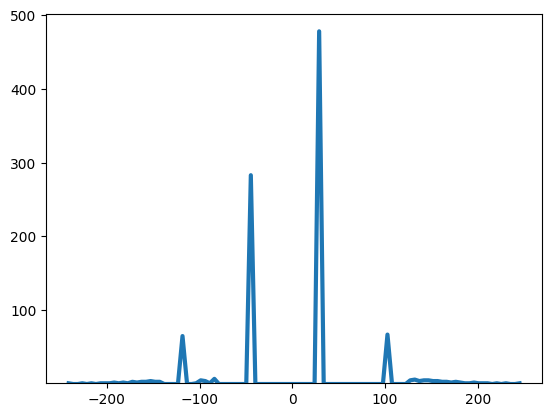

In [398]:
th = ((theta[-1] - theta[-5000] )//(np.pi*2))
c,b = np.histogram(th,bins=100)
plt.plot(b[1:],c,lw=3)
plt.ylim(1,)

In [359]:
def Get_Group(TH_s,TH_e,L,dt):
    ARG = (TH_s-TH_e)//(2*np.pi)
    ARG =  np.where(ARG<0,ARG,ARG)
    u,c = np.unique(ARG,return_counts=True)

    I_c_o1 =np.where(c>5)
    u_o1 = u[I_c_o1]
    c_o1 = c[I_c_o1]
    u_c = np.argsort(c_o1)[::-1]
    UU = u_o1[u_c]

    arr = UU
    main_value = np.min(abs(arr))
    adjusted_arr = arr - main_value
    abs_arr = np.unique(np.abs(adjusted_arr))
    abs_arr
    group_threshold = 5
    G = {}
    GP = {}
    GM = {}
    GN = {}
    G_num = 0
    GP_num = 1
    GM_num = 1
    I_num = 1
    for i in range(1,5):
        GP[i,'I'] = []
        GP[i,'R'] = np.nan
        GP[i,'L'] = np.nan
        GP[i,'V'] = np.nan
        GM[i,'I'] = []
        GM[i,'R'] = np.nan
        GM[i,'L'] = np.nan
        GM[i,'V'] = np.nan
    for i in range(5):
        abs_arr = np.unique(np.abs(adjusted_arr))
        for num in abs_arr:
            abs_adjust_arr = np.abs(adjusted_arr)
            in_group = np.int64(np.round((abs_adjust_arr-num)/group_threshold)) * group_threshold
            is_group = np.where(abs(in_group) < 1)
            not_group = np.where(in_group >= 1)
            if len(is_group) != 0:
                Ra_arr = adjusted_arr[is_group]
                R = Ra_arr + main_value
                if G_num == 0:
                    I, = np.where(np.isin(ARG,R))
                    G[G_num,'I'] = I
                    G[G_num,'R'] = R
                    G[G_num,'L'] = len(I)
                    G[G_num,'V'] = np.mean(R/(L-1)/dt)
                    G_num +=1
                else:
                    gp_idx, = np.where(Ra_arr>0)
                    gm_idx, = np.where(Ra_arr<0)
                    Rp = R[gp_idx]
                    Rm = R[gm_idx]
                    Ip, = np.where(np.isin(ARG,Rp))
                    Im, = np.where(np.isin(ARG,Rm))
                    if (len(Rp) !=0) and (len(Rm) != 0):
                        GM[GM_num,'I'] = Im
                        GM[GM_num,'R'] = Rm
                        GM[GM_num,'V'] = np.mean(Rm/(L-1)/dt)
                        GM[GM_num,'L'] = len(Im)
                        GP[GP_num,'I'] = Ip
                        GP[GP_num,'R'] = Rp
                        GP[GP_num,'V'] = np.mean(Rp/(L-1)/dt)
                        GP[GP_num,'L'] = len(Ip)
                        GP_num += 1
                        GM_num += 1
                    elif (len(Rp) !=0):
                        GP[GP_num,'I'] = Ip
                        GP[GP_num,'R'] = Rp
                        GP[GP_num,'L'] = len(Ip)
                        GP[GP_num,'V'] = np.mean(Rp/(L-1)/dt)

                        GP_num += 1
                    else:
                        GM[GM_num,'I'] = Im
                        GM[GM_num,'R'] = Rm
                        GM[GM_num,'L'] = len(Im)
                        GM[GM_num,'V'] = np.mean(Rm/(L-1)/dt)

                        GM_num += 1

            adjusted_arr = adjusted_arr[not_group]
            break
    return G,GM,GP

# cluster check
이상하게 겹쳐있는 데이터는 없에야 함
그렇다면 어떤 조건을 가지고 이걸 제거 할 수 있을까?
3개의 변화가 생각보다 작아야 함

0
106
265
39
18
18
5


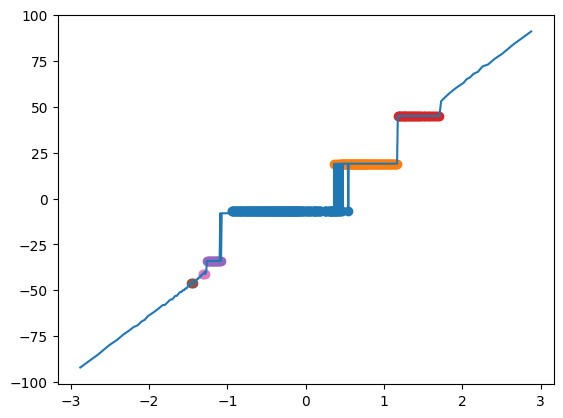

In [395]:
un,ui,uc = np.unique(th,return_index=True,return_counts=True,)
uci = np.argsort(uc)
plt.plot(omega,th)
for i in un[uci][:-8:-1]:
    X, = np.where(th==i)
    th = np.where(np.abs(th-i)<5,i,th)
    plt.scatter(omega[X],th[X],label=f'{i},{len(X)}')
    

    # print(np.unique(np.diff(X),return_counts=True))

# un,ui,uc = np.unique(th,return_index=True,return_counts=True,)
# uct, = np.where(uc>TH)
# un,ui,uc = un[uct],ui[uct],uc[uct]
# uci = np.argsort(uc)

for i in un[uci][:-8:-1]:
    X, = np.where(th==i)
    print(len(X))
    # plt.scatter(X,th[X],label=f'{i},{len(X)}')
    # print(np.unique(np.diff(X),return_counts=True))


In [361]:
TH = 10000
TH_S,TH_E,L = theta[-1],theta[-TH],TH
G,GM,GP = Get_Group(TH_S,TH_E,L,dt =dt)

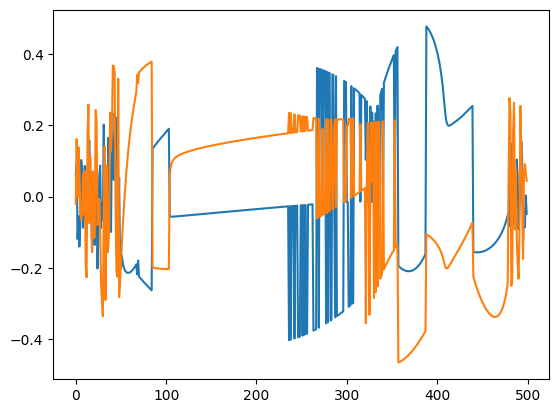

In [362]:
plt.plot(dtheta[-1]-dtheta[-1000])
plt.plot(dtheta[-1]-dtheta[-4000])


In [363]:
def get_indx(th,rs,N,t_idx): 
    th = np.where(th>=0,th,th+1)
    th = th/(t[-1] - t[-t_idx])
    c,b = np.histogram(th,bins=100)
    c_sort = np.sort(c)[::-1]
    c_3 = np.where(c_sort>np.max(c)*(0.05))
    print(np.max(c)/50)
    c_arg = np.argsort(c)[::-1]
    b_n0 = b[c_arg[c_3]]
    db = b[1] - b[0]
    gs = {}
    gs['group #'] = []
    gs['group rot'] = []
    gs['group idx'] = []
    if np.mean(rs)>1/np.sqrt(N):
        for b_l in b_n0:
            idx, = np.where((th>=b_l)&(th<=b_l+db))
            print(np.std(th[idx]))
            gs['group idx'].append(idx)
            gs['group rot'].append(np.mean(th[idx])*(np.pi*2))
            gs['group #'].append(len(idx))
    return pd.DataFrame(gs)


In [399]:
th = (theta[-1] - theta[-1000])//(np.pi*2)
t_idx = 2000
th = (theta[-1] - theta[-t_idx])//(np.pi*2)
df_g = get_indx(th,rs[-500:],N,t_idx)

9.56
0.0
1.3877787807814457e-17
2.7755575615628914e-17
0.0


In [375]:
ths = [(dtheta[-1-i]-dtheta[-1000-i]) for i in range(1000)]
ths = np.array(ths)
sths = np.mean(ths, axis=0)


In [400]:
for idx in df_g['group idx']:
    s = np.unique(np.sign(np.diff(ths[0][idx])))
    print(s)
    if len(s)== 1 &(-1 in s):
        plt.scatter(idx,ths[0][idx],marker='.',zorder=3)
plt.plot(ths[0])


IndexError: index 500 is out of bounds for axis 0 with size 500

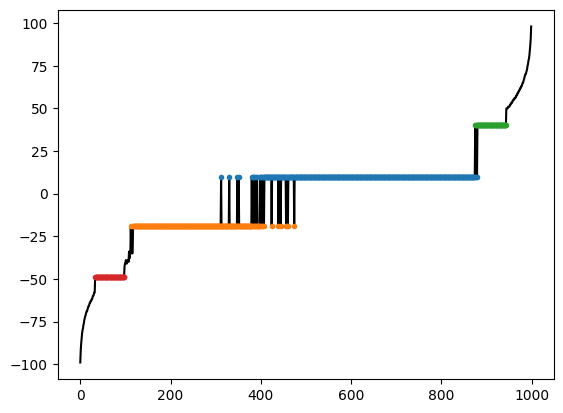

In [401]:
for idx in df_g['group idx']:
    plt.scatter(idx,th[idx],marker='.',zorder=3)
plt.plot(th,color='black')

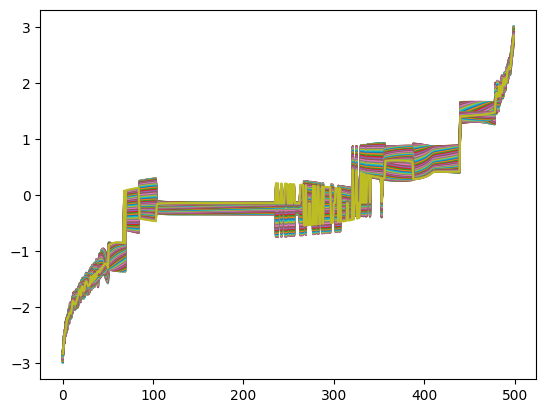

In [384]:
for i in range(1,100):
    plt.plot(dtheta[-i])

In [402]:
df_g['group abs rot2'] = (df_g['group rot']-(df_g['group rot'].iloc[0]+df_g['group rot'].iloc[1])/2).apply(lambda x: np.abs(x))
df_g['group abs rot'] = (df_g['group rot']-(df_g['group rot'].iloc[0])).apply(lambda x: np.abs(x))

In [403]:
df_g

,group #,group rot,group idx,group abs rot2,group abs rot
0,478,0.314316,"[312, 330, 348, 351, 380, 382, 385, 386, 390, ...",0.440043,0.000000
1,283,-0.565770,"[112, 117, 118, 119, 120, 121, 122, 123, 124, ...",0.440043,0.880086
2,67,1.257266,"[875, 876, 878, 880, 881, 882, 883, 884, 885, ...",1.382992,0.942949
3,65,-1.508719,"[33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 4...",1.382992,1.823035


In [419]:
c,b = np.histogram(df_g[['group abs rot2']])
if max(c)>1:
    print(c)
    i0,=np.where(c>0)
    c0 = c[i0]
    print(c0)
    b_l,b_r = b[i0],b[i0+1]
else:
    c,b = np.histogram(df_g[['group abs rot']])
    i0,=np.where(c>0)
    c0 = c[i0]
    print(c0)
    b_l,b_r = b[i0],b[i0+1]

[2 0 0 0 0 0 0 0 0 2]
[2 2]


In [417]:
c,b = np.histogram(df_g[['group abs rot']])
c

array([1, 0, 0, 0, 1, 1, 0, 0, 0, 1])

array([[<Axes: title={'center': 'group abs rot2'}>]], dtype=object)

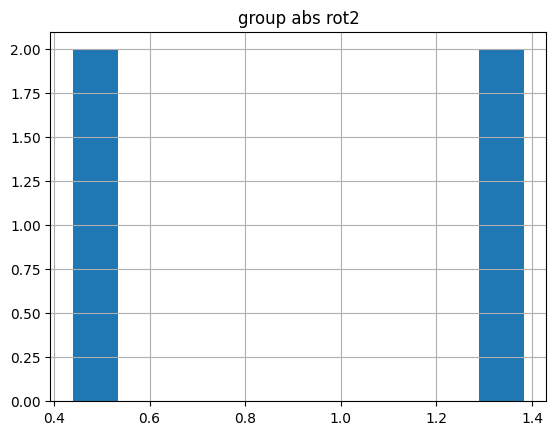

In [418]:
df_g[['group abs rot2']].hist()

In [387]:
for i in df_g[['group rot','group abs rot2','group abs rot']].values:
    print(i)

[-0.19440174  0.39580147  0.        ]
[0.5972012  0.39580147 0.79160295]
[1.41442391 1.21302418 1.60882565]
[-1.0372442   1.23864393  0.84284246]
